# PART 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, recall_score
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings("ignore")

In [199]:
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('grade2')

IndexError: list index out of range

In [2]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

In [3]:
p = 1000
n = [250, 500, 750]
sparsity = [0.7, 0.85, 0.9, 0.99]



In [4]:
mse_alpha_lse_test = []
mse_alpha_min_test = []
mse_alpha_lse_train = []
mse_alpha_min_train = []
sensitivity_alpha_lse = []
sensitivity_alpha_min = []
specificity_alpha_lse = []
specificity_alpha_min = []

for i in range(4):
    for j in n:
        for k in sparsity:
            d = simulate_data(j, 1000, np.random.default_rng(), sparsity = k)
            beta_true = d[2]
            selected_features_true = []
            for p in range(len(beta_true)):
                if beta_true[p] != 0:
                    selected_features_true.append(1)
                else:
                    selected_features_true.append(0)
                
                
            X_train, X_test, y_train, y_test = train_test_split(d[0], d[1], test_size = 0.3)
            lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
            predictions = lasso.predict(X_test)
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
                (cv_mean >= cv_mean[idx_min_mean]))[0][0]
            alpha_lse = lasso.alphas_[idx_alpha].max()
            alpha_min = lasso.alphas_[idx_min_mean]
            
            #Fitting lasso regression for alpha_lse
            X_train2, X_test2, y_train2, y_test2 = train_test_split(d[0], d[1], test_size = 0.3)
            lasso2 = Lasso(alpha = alpha_lse).fit(X_train2, y_train2)
            predictions2 = lasso2.predict(X_test2)
            mse2 = mean_squared_error(y_test2, predictions2) #Testing error
            mse_alpha_lse_test.append(mse2)
            preds2 = lasso2.predict(X_train2)
            mse22 = mean_squared_error(y_train2, preds2) #Training error
            mse_alpha_lse_train.append(mse22)
            beta_est2 = lasso2.coef_
            selected_features_est2 = []
            for q in range(len(beta_est2)):
                if beta_est2[q] != 0:
                    selected_features_est2.append(1)
                else:
                    selected_features_est2.append(0)
            sensitivity2 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 1 and selected_features_est2[w] == 1:
                    sensitivity2.append(1)
                elif selected_features_true[w] == 1 and selected_features_est2[w] == 0:
                    sensitivity2.append(0)
                else:
                    pass
            sensitivity_alpha_lse.append(sum(sensitivity2)/len(sensitivity2))
            
            specificity2 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 0 and selected_features_est2[w] == 0:
                    specificity2.append(1)
                elif selected_features_true[w] == 0 and selected_features_est2[w] == 1:
                    specificity2.append(0)
                else:
                    pass
            specificity_alpha_lse.append(sum(specificity2)/len(specificity2))
            
                    
                    
            
            #Fitting lasso regression for alpha_min
            X_train3, X_test3, y_train3, y_test3 = train_test_split(d[0], d[1], test_size = 0.3)
            lasso3 = Lasso(alpha = alpha_min).fit(X_train3, y_train3)
            predictions3 = lasso3.predict(X_test3)
            mse3 = mean_squared_error(y_test3, predictions3)
            mse_alpha_min_test.append(mse3)
            preds3 = lasso2.predict(X_train3)
            mse33 = mean_squared_error(y_train3, preds3)
            mse_alpha_min_train.append(mse33)
            beta_est3 = lasso3.coef_
            selected_features_est3 = []
            for r in range(len(beta_est3)):
                if beta_est3[r] != 0:
                    selected_features_est3.append(1)
                else:
                    selected_features_est3.append(0)
            
            sensitivity3 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 1 and selected_features_est3[w] == 1:
                    sensitivity3.append(1)
                elif selected_features_true[w] == 1 and selected_features_est3[w] == 0:
                    sensitivity3.append(0)
                else:
                    pass
            sensitivity_alpha_min.append(sum(sensitivity3)/len(sensitivity3))
            
            specificity3 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 0 and selected_features_est3[w] == 0:
                    specificity3.append(1)
                elif selected_features_true[w] == 0 and selected_features_est3[w] == 1:
                    specificity3.append(0)
                else:
                    pass
            specificity_alpha_min.append(sum(specificity3)/len(specificity3))
            
            
            

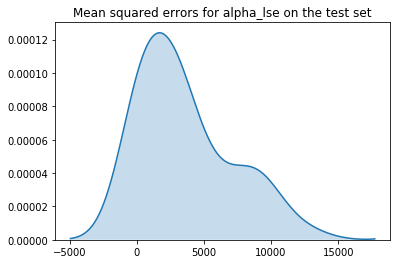

In [22]:
plt.title('Mean squared errors for alpha_lse on the test set')
sns.kdeplot(data = mse_alpha_lse_test, shade = True)

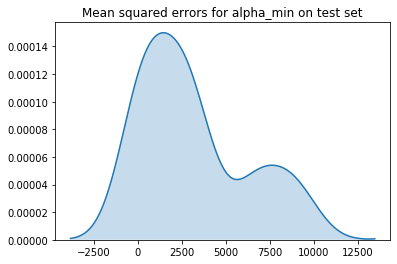

In [23]:
plt.title('Mean squared errors for alpha_min on test set')
sns.kdeplot(data = mse_alpha_min_test, shade = True)

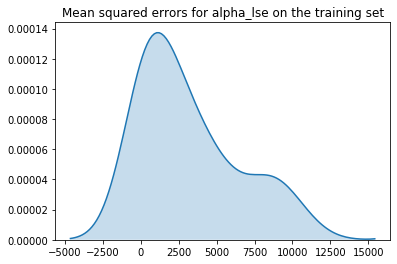

In [24]:
plt.title('Mean squared errors for alpha_lse on the training set')
sns.kdeplot(data = mse_alpha_lse_train, shade = True)

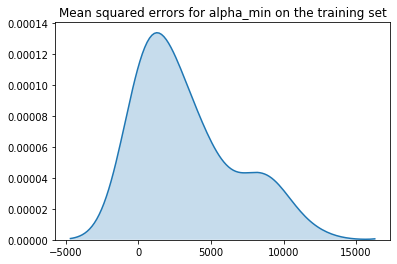

In [25]:
plt.title('Mean squared errors for alpha_min on the training set')
sns.kdeplot(data = mse_alpha_min_train, shade = True)

#### We first compare sensitivity of alpha_lse and alpha_min

In [26]:
l11 = max(sensitivity_alpha_lse)

print("Maximum sensitivity of alpha_lse: ", round(l11,3))

l1 = sum(sensitivity_alpha_lse)/len(sensitivity_alpha_lse)

print("Average sensitivity of alpha_lse: ", round(l1,3))

l22 = max(sensitivity_alpha_min)

print("Maximum sensitivity of alpha_min: ", round(l22,3))

l2 = sum(sensitivity_alpha_min)/len(sensitivity_alpha_min)

print("Average sensitivity of alpha_min: ", round(l2,3))



Maximum sensitivity of alpha_lse:  0.909
Average sensitivity of alpha_lse:  0.332
Maximum sensitivity of alpha_min:  1.0
Average sensitivity of alpha_min:  0.479


#### We now compare specificity of alpha_lse and alpha_min

In [27]:
print("Maximum specificity of alpha_lse: ", max(specificity_alpha_lse))

l3 = sum(specificity_alpha_lse)/len(specificity_alpha_lse)

print("Average specificity of alpha_lse: ", round(l3,3))

print("Maximum specificity of alpha_min: ", max(specificity_alpha_min))

l4 = sum(specificity_alpha_min)/len(specificity_alpha_min)

print("Average specificity of alpha_min: ", round(l4,3))

Maximum specificity of alpha_lse:  1.0
Average specificity of alpha_lse:  0.984
Maximum specificity of alpha_min:  1.0
Average specificity of alpha_min:  0.917


#### We now plot sensitivty and specificity of alpha_lse

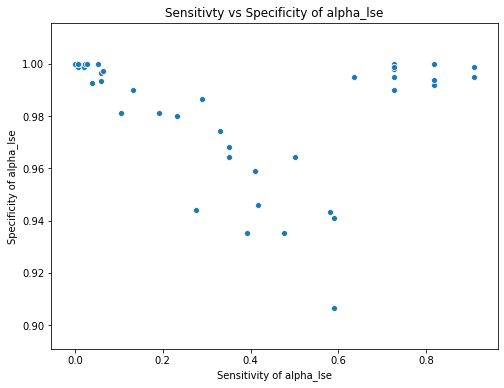

In [28]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_lse')
plt.ylabel('Specificity of alpha_lse')
plt.title('Sensitivty vs Specificity of alpha_lse')
sns.scatterplot(x = sensitivity_alpha_lse, y = specificity_alpha_lse)

#### We now plot sensitivty and specificity of alpha_min

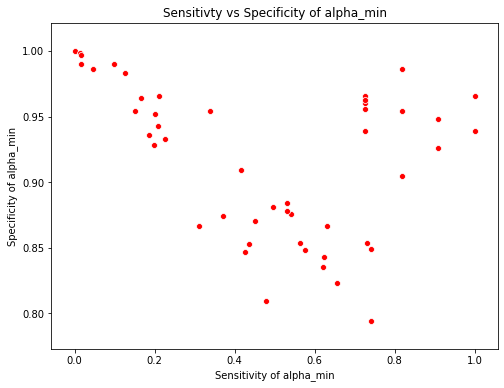

In [29]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_min')
plt.ylabel('Specificity of alpha_min')
plt.title('Sensitivty vs Specificity of alpha_min')
sns.scatterplot(x = sensitivity_alpha_min, y = specificity_alpha_min, color = 'r')

#### We now try to see how different values of n affect the relationship between sensitivity and specificity. In order to check the influence of only n, we keep the other parameters as constant and repeat the experiment again. 

In [5]:
n2 = np.arange(100, 975, 25)

In [11]:
len(n2)

35

In [6]:
mse_alpha_lse2_test = []
mse_alpha_min2_test = []
mse_alpha_lse2_train = []
mse_alpha_min2_train = []
sensitivity_alpha_lse2 = []
sensitivity_alpha_min2 = []
specificity_alpha_lse2 = []
specificity_alpha_min2 = []

#for i in range(4):
for j in n2:
        #for k in sparsity:
            d = simulate_data(j, 1000, np.random.default_rng(), sparsity = 0.9)
            beta_true = d[2]
            selected_features_true = []
            for p in range(len(beta_true)):
                if beta_true[p] != 0:
                    selected_features_true.append(1)
                else:
                    selected_features_true.append(0)
                
                
            X_train, X_test, y_train, y_test = train_test_split(d[0], d[1], test_size = 0.3)
            lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
            predictions = lasso.predict(X_test)
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
                (cv_mean >= cv_mean[idx_min_mean]))[0][0]
            alpha_lse = lasso.alphas_[idx_alpha].max()
            alpha_min = lasso.alphas_[idx_min_mean]
            
            #Fitting lasso regression for alpha_lse
            X_train2, X_test2, y_train2, y_test2 = train_test_split(d[0], d[1], test_size = 0.3)
            lasso2 = Lasso(alpha = alpha_lse).fit(X_train2, y_train2)
            predictions2 = lasso2.predict(X_test2)
            mse2 = mean_squared_error(y_test2, predictions2)
            mse_alpha_lse2_test.append(mse2)
            preds2 = lasso2.predict(X_train2)
            mse22 = mean_squared_error(y_train2, preds2)
            mse_alpha_lse2_train.append(mse22)
            beta_est2 = lasso2.coef_
            selected_features_est2 = []
            for q in range(len(beta_est2)):
                if beta_est2[q] != 0:
                    selected_features_est2.append(1)
                else:
                    selected_features_est2.append(0)
            sensitivity2 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 1 and selected_features_est2[w] == 1:
                    sensitivity2.append(1)
                elif selected_features_true[w] == 1 and selected_features_est2[w] == 0:
                    sensitivity2.append(0)
                else:
                    pass
            sensitivity_alpha_lse2.append(sum(sensitivity2)/len(sensitivity2))
            
            specificity2 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 0 and selected_features_est2[w] == 0:
                    specificity2.append(1)
                elif selected_features_true[w] == 0 and selected_features_est2[w] == 1:
                    specificity2.append(0)
                else:
                    pass
            specificity_alpha_lse2.append(sum(specificity2)/len(specificity2))
            
                    
                    
            
            #Fitting lasso regression for alpha_min
            X_train3, X_test3, y_train3, y_test3 = train_test_split(d[0], d[1], test_size = 0.3)
            lasso3 = Lasso(alpha = alpha_min).fit(X_train3, y_train3)
            predictions3 = lasso3.predict(X_test3)
            mse3 = mean_squared_error(y_test3, predictions3)
            mse_alpha_min2_test.append(mse3)
            preds3 = lasso3.predict(X_train3)
            mse33 = mean_squared_error(y_train3, preds3)
            mse_alpha_min2_train.append(mse33)
            
            beta_est3 = lasso3.coef_
            selected_features_est3 = []
            for r in range(len(beta_est3)):
                if beta_est3[r] != 0:
                    selected_features_est3.append(1)
                else:
                    selected_features_est3.append(0)
            
            sensitivity3 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 1 and selected_features_est3[w] == 1:
                    sensitivity3.append(1)
                elif selected_features_true[w] == 1 and selected_features_est3[w] == 0:
                    sensitivity3.append(0)
                else:
                    pass
            sensitivity_alpha_min2.append(sum(sensitivity3)/len(sensitivity3))
            
            specificity3 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 0 and selected_features_est3[w] == 0:
                    specificity3.append(1)
                elif selected_features_true[w] == 0 and selected_features_est3[w] == 1:
                    specificity3.append(0)
                else:
                    pass
            specificity_alpha_min2.append(sum(specificity3)/len(specificity3))

#### We now plot the sensitivity, specificty and mean square errors of alpha_lse against various values of n.

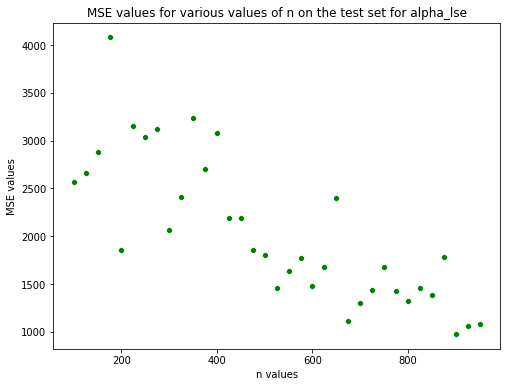

In [32]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of n on the test set for alpha_lse')
sns.scatterplot(x = n2, y = mse_alpha_lse2_test, color = 'g')

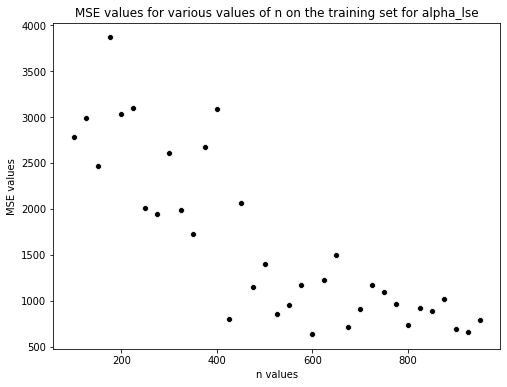

In [33]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of n on the training set for alpha_lse')
sns.scatterplot(x = n2, y = mse_alpha_lse2_train, color = 'black')

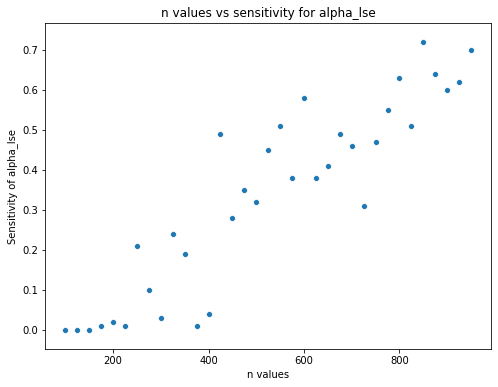

In [34]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('Sensitivity of alpha_lse')
plt.title('n values vs sensitivity for alpha_lse')
sns.scatterplot(x = n2, y = sensitivity_alpha_lse2)

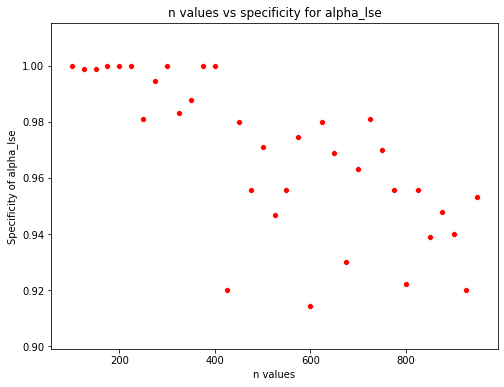

In [35]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('Specificity of alpha_lse')
plt.title('n values vs specificity for alpha_lse')
sns.scatterplot(x = n2, y = specificity_alpha_lse2, color = 'r')

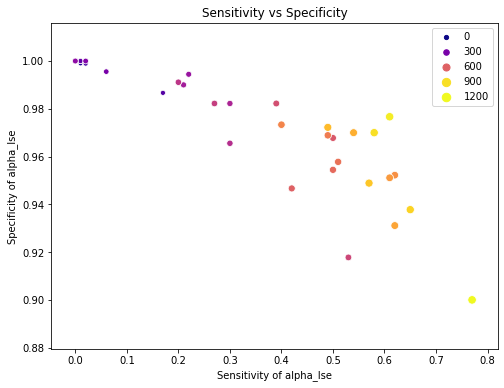

In [150]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_lse')
plt.ylabel('Specificity of alpha_lse')
plt.title('Sensitivity vs Specificity')
sns.scatterplot(x = sensitivity_alpha_lse2, y = specificity_alpha_lse2, hue = n2, palette = 'plasma', size = n2)

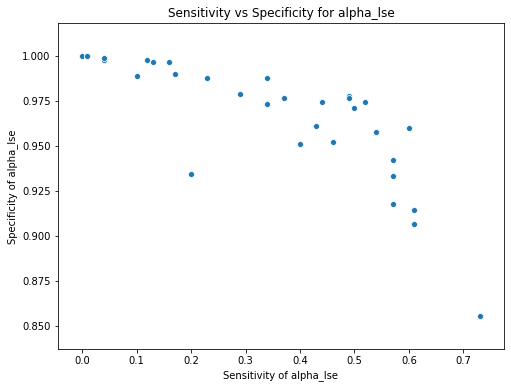

In [10]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_lse')
plt.ylabel('Specificity of alpha_lse')
plt.title('Sensitivity vs Specificity for alpha_lse')
sns.scatterplot(x = sensitivity_alpha_lse2, y = specificity_alpha_lse2)

#### We now plot the sensitivity, specificty and mean squared errors of alpha_min against various values of n.

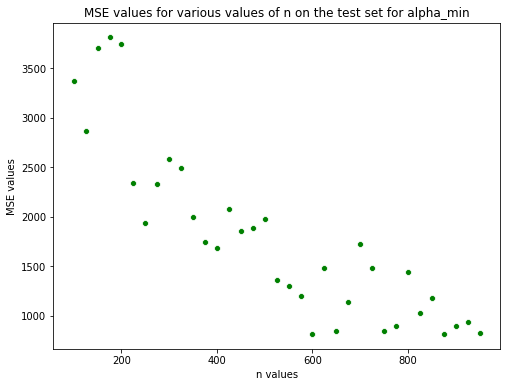

In [114]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of n on the test set for alpha_min')
sns.scatterplot(x = n2, y = mse_alpha_min2_test, color = 'g')

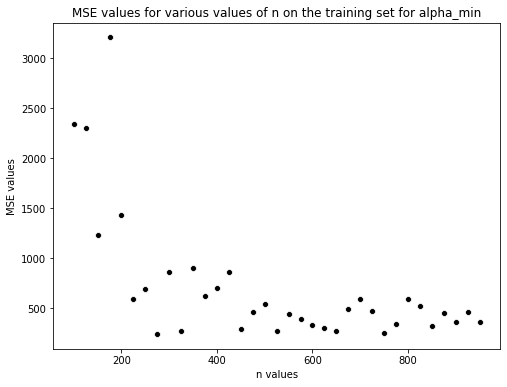

In [115]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of n on the training set for alpha_min')
sns.scatterplot(x = n2, y = mse_alpha_min2_train, color = 'black')

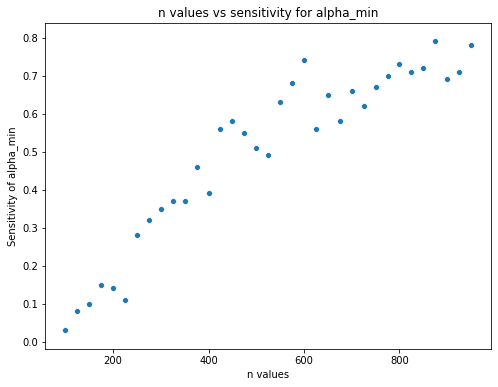

In [36]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('Sensitivity of alpha_min')
plt.title('n values vs sensitivity for alpha_min')
sns.scatterplot(x = n2, y = sensitivity_alpha_min2)

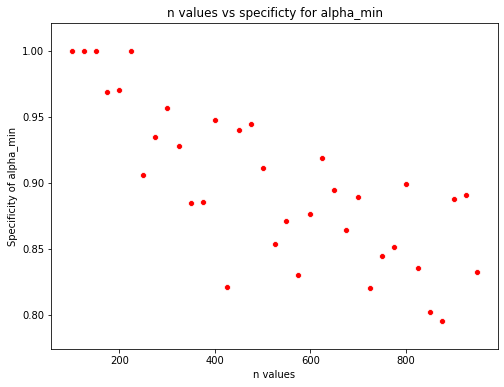

In [11]:
plt.figure(figsize = (8,6))
plt.xlabel('n values')
plt.ylabel('Specificity of alpha_min')
plt.title('n values vs specificty for alpha_min')
sns.scatterplot(x = n2, y = specificity_alpha_min2, color = 'r')

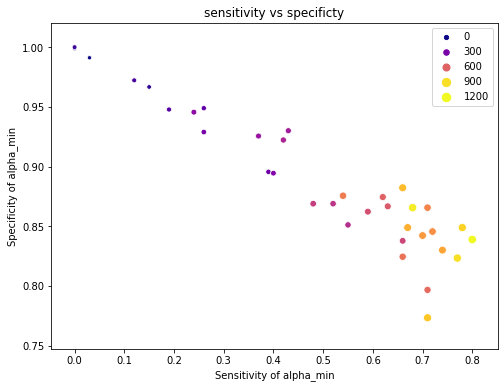

In [162]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_min')
plt.ylabel('Specificity of alpha_min')
plt.title('sensitivity vs specificty')
sns.scatterplot(x = sensitivity_alpha_min2, y = specificity_alpha_min2, hue = n2,hue_order = ["0", "300", "600", "900", "1000"], palette = 'plasma', size = n2)

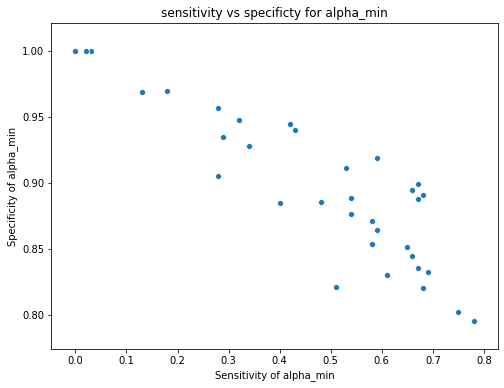

In [12]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_min')
plt.ylabel('Specificity of alpha_min')
plt.title('sensitivity vs specificty for alpha_min')
sns.scatterplot(x = sensitivity_alpha_min2, y = specificity_alpha_min2)

#### We now repeat the experiment again, but this time vary the sparsity values and keep everything else constant.

In [7]:
sparsity2 = np.linspace(0.5,1,num = 35, endpoint = False)

In [8]:
mse_alpha_lse3_test = []
mse_alpha_min3_test = []
mse_alpha_lse3_train = []
mse_alpha_min3_train = []
sensitivity_alpha_lse3 = []
sensitivity_alpha_min3 = []
specificity_alpha_lse3 = []
specificity_alpha_min3 = []

#for i in range(4):
#for j in n2:
for k in sparsity2:
            d = simulate_data(500, 1000, np.random.default_rng(), sparsity = k)
            beta_true = d[2]
            selected_features_true = []
            for p in range(len(beta_true)):
                if beta_true[p] != 0:
                    selected_features_true.append(1)
                else:
                    selected_features_true.append(0)
                
                
            X_train, X_test, y_train, y_test = train_test_split(d[0], d[1], test_size = 0.3)
            lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
            predictions = lasso.predict(X_test)
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
                (cv_mean >= cv_mean[idx_min_mean]))[0][0]
            alpha_lse = lasso.alphas_[idx_alpha].max()
            alpha_min = lasso.alphas_[idx_min_mean]
            
            #Fitting lasso regression for alpha_lse
            X_train2, X_test2, y_train2, y_test2 = train_test_split(d[0], d[1], test_size = 0.3)
            lasso2 = Lasso(alpha = alpha_lse).fit(X_train2, y_train2)
            predictions2 = lasso2.predict(X_test2)
            mse2 = mean_squared_error(y_test2, predictions2)
            mse_alpha_lse3_test.append(mse2)
            preds2 = lasso2.predict(X_train2)
            mse22 = mean_squared_error(y_train2, preds2)
            mse_alpha_lse3_train.append(mse22)
            beta_est2 = lasso2.coef_
            selected_features_est2 = []
            for q in range(len(beta_est2)):
                if beta_est2[q] != 0:
                    selected_features_est2.append(1)
                else:
                    selected_features_est2.append(0)
            sensitivity2 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 1 and selected_features_est2[w] == 1:
                    sensitivity2.append(1)
                elif selected_features_true[w] == 1 and selected_features_est2[w] == 0:
                    sensitivity2.append(0)
                else:
                    pass
            sensitivity_alpha_lse3.append(sum(sensitivity2)/len(sensitivity2))
            
            specificity2 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 0 and selected_features_est2[w] == 0:
                    specificity2.append(1)
                elif selected_features_true[w] == 0 and selected_features_est2[w] == 1:
                    specificity2.append(0)
                else:
                    pass
            specificity_alpha_lse3.append(sum(specificity2)/len(specificity2))
            
                    
                    
            
            #Fitting lasso regression for alpha_min
            X_train3, X_test3, y_train3, y_test3 = train_test_split(d[0], d[1], test_size = 0.3)
            lasso3 = Lasso(alpha = alpha_min).fit(X_train3, y_train3)
            predictions3 = lasso3.predict(X_test3)
            mse3 = mean_squared_error(y_test3, predictions3)
            mse_alpha_min3_test.append(mse3)
            preds3 = lasso3.predict(X_train3)
            mse33 = mean_squared_error(y_train3, preds3)
            mse_alpha_min3_train.append(mse33)
            beta_est3 = lasso3.coef_
            selected_features_est3 = []
            for r in range(len(beta_est3)):
                if beta_est3[r] != 0:
                    selected_features_est3.append(1)
                else:
                    selected_features_est3.append(0)
            
            sensitivity3 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 1 and selected_features_est3[w] == 1:
                    sensitivity3.append(1)
                elif selected_features_true[w] == 1 and selected_features_est3[w] == 0:
                    sensitivity3.append(0)
                else:
                    pass
            sensitivity_alpha_min3.append(sum(sensitivity3)/len(sensitivity3))
            
            specificity3 = []
            for w in range(len(selected_features_true)):
                if selected_features_true[w] == 0 and selected_features_est3[w] == 0:
                    specificity3.append(1)
                elif selected_features_true[w] == 0 and selected_features_est3[w] == 1:
                    specificity3.append(0)
                else:
                    pass
            specificity_alpha_min3.append(sum(specificity3)/len(specificity3))

#### We now plot the sensitivity and specificty of alpha_lse against various values of sparsity.

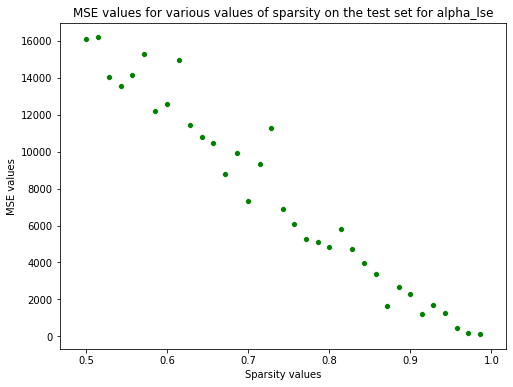

In [40]:
plt.figure(figsize = (8,6))
plt.xlabel('Sparsity values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of sparsity on the test set for alpha_lse')
sns.scatterplot(x = sparsity2, y = mse_alpha_lse3_test, color = 'g')

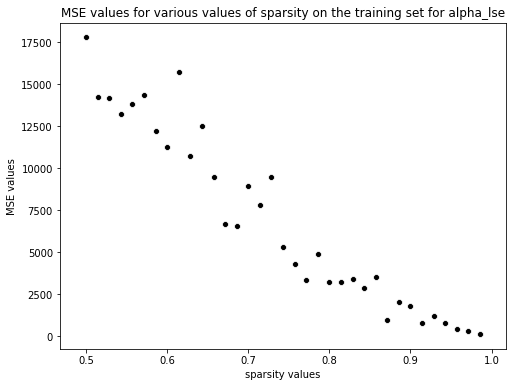

In [41]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of sparsity on the training set for alpha_lse')
sns.scatterplot(x = sparsity2, y = mse_alpha_lse3_train, color = 'black')

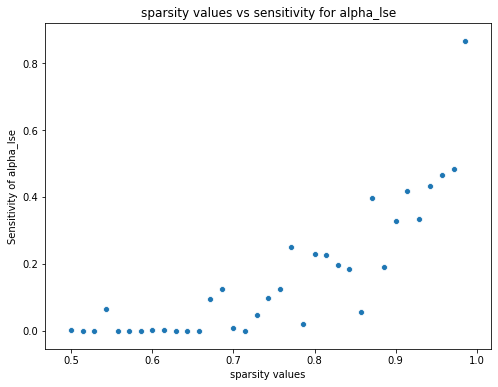

In [44]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('Sensitivity of alpha_lse')
plt.title('sparsity values vs sensitivity for alpha_lse')
sns.scatterplot(x = sparsity2, y = sensitivity_alpha_lse3)

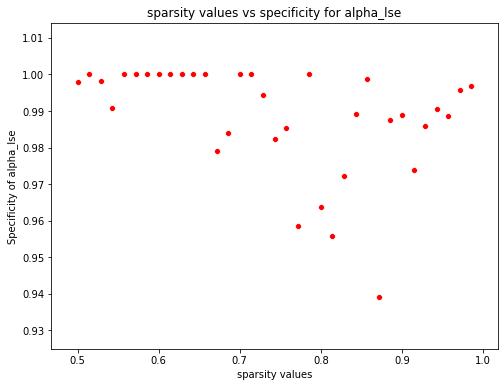

In [45]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('Specificity of alpha_lse')
plt.title('sparsity values vs specificity for alpha_lse')
sns.scatterplot(x = sparsity2, y = specificity_alpha_lse3, color = 'r')

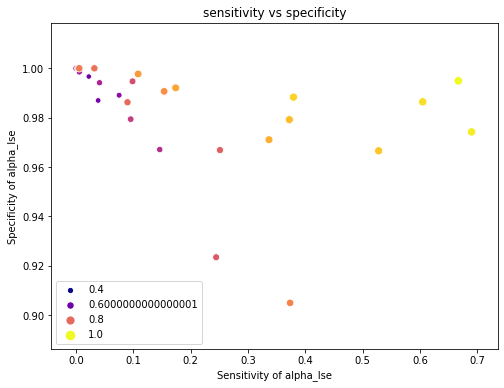

In [159]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_lse')
plt.ylabel('Specificity of alpha_lse')
plt.title('sensitivity vs specificity for alpha_lse')
order = ["0-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]
sns.scatterplot(x = sensitivity_alpha_lse3, y = specificity_alpha_lse3, hue_order = order, hue = sparsity2, palette = 'plasma', size = sparsity2)

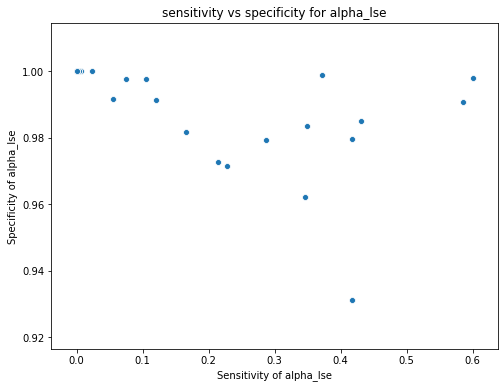

In [13]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_lse')
plt.ylabel('Specificity of alpha_lse')
plt.title('sensitivity vs specificity for alpha_lse')
order = ["0-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]
sns.scatterplot(x = sensitivity_alpha_lse3, y = specificity_alpha_lse3)

#### We now plot the sensitivity and specificty of alpha_min against various values of sparsity.

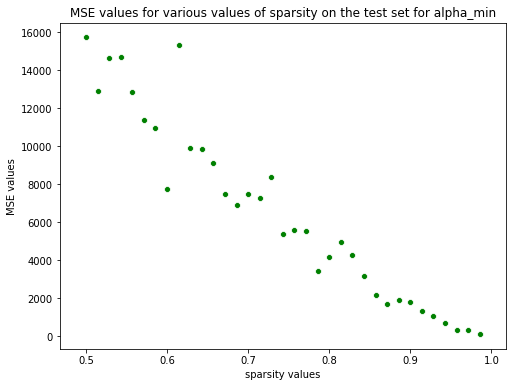

In [42]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of sparsity on the test set for alpha_min')
sns.scatterplot(x = sparsity2, y = mse_alpha_min3_test, color = 'g')

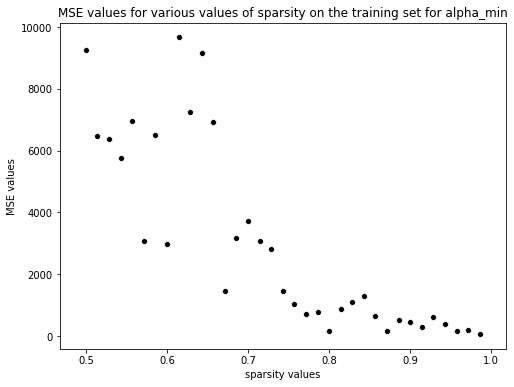

In [43]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('MSE values')
plt.title('MSE values for various values of sparsity on the training set for alpha_min')
sns.scatterplot(x = sparsity2, y = mse_alpha_min3_train, color = 'black')

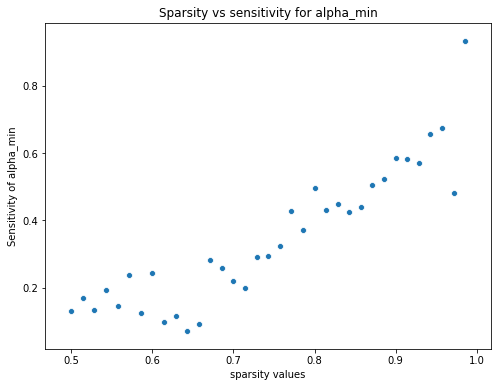

In [46]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('Sensitivity of alpha_min')
plt.title('Sparsity vs sensitivity for alpha_min')
sns.scatterplot(x = sparsity2, y = sensitivity_alpha_min3)

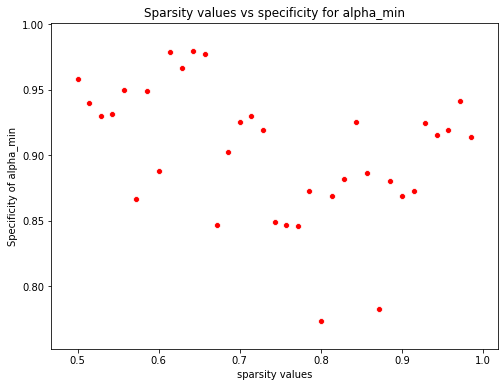

In [47]:
plt.figure(figsize = (8,6))
plt.xlabel('sparsity values')
plt.ylabel('Specificity of alpha_min')
plt.title('Sparsity values vs specificity for alpha_min')
sns.scatterplot(x = sparsity2, y = specificity_alpha_min3, color = 'r')

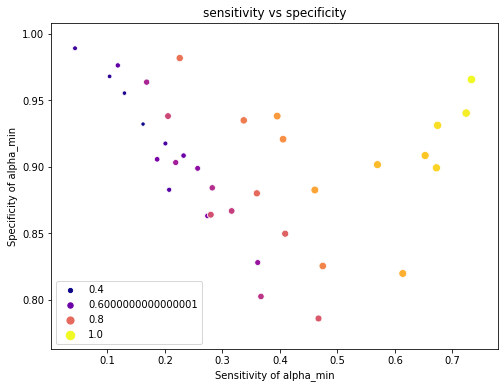

In [165]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_min')
plt.ylabel('Specificity of alpha_min')
plt.title('sensitivity vs specificity for alpha_min')
sns.scatterplot(x = sensitivity_alpha_min3, y = specificity_alpha_min3, hue = sparsity2, palette = 'plasma', size = sparsity2)

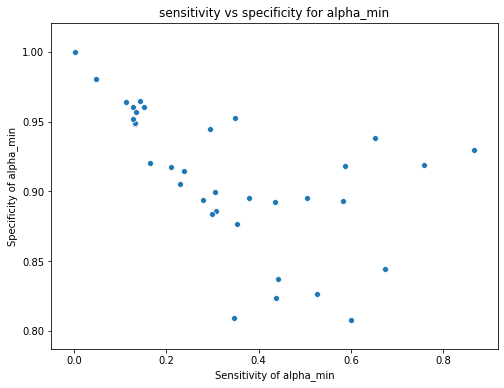

In [14]:
plt.figure(figsize = (8,6))
plt.xlabel('Sensitivity of alpha_min')
plt.ylabel('Specificity of alpha_min')
plt.title('sensitivity vs specificity for alpha_min')
sns.scatterplot(x = sensitivity_alpha_min3, y = specificity_alpha_min3)

# PART 2

#### We use the gene expression dataset again. 

In [160]:
data = pd.read_csv("E:\Masters\Lp4\Statistical Learning for Big Data\Project 2\TCGA-PANCAN-HiSeq-801x20531\data.csv", index_col = 0)

In [161]:
labels = pd.read_csv("E:\Masters\Lp4\Statistical Learning for Big Data\Project 2\TCGA-PANCAN-HiSeq-801x20531\labels.csv", index_col = 0)

#### We perform feature reduction based on the f-score and reduce the number of features to 200.

In [4]:
labels

,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA
...,...
sample_796,BRCA
sample_797,LUAD
sample_798,COAD
sample_799,PRAD


In [162]:
data_new = SelectKBest(k = 200).fit_transform(data, labels)

In [6]:
data.shape

(801, 20531)

In [7]:
data_new.shape

(801, 200)

In [188]:
len(data_new)

801

In [8]:
labels.shape

(801, 1)

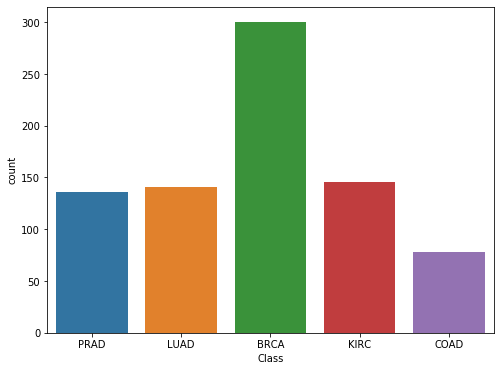

In [195]:
plt.figure(figsize = (8,6))
sns.countplot(x = 'Class', data = labels)

In [17]:
data_new_withlabels = pd.concat([pd.DataFrame(data_new), labels])

### Our next objective is to fit a multi-class logistic regression model and determine suitable hyperparameters for each class. There are 5 classes, so we should obtain 5 sets of hyperparameters.

In [200]:
X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)

In [39]:
#model2 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000)

In [40]:
#model2.fit(X_train, np.asarray(y_train).ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=10000, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_preds = model.predict(X_test)

In [47]:
#model.score(X_test, y_test)

0.995850622406639

In [48]:
#cm = confusion_matrix(y_test, y_preds)

In [164]:
# C_values = np.logspace(-4, 4, 30)
# model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000, 
#                              Cs = C_values, scoring = 'f1_micro')
# model.fit(X_train, y_train)

In [201]:
# model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000, Cs = C_values, scoring = 'roc_auc')

In [354]:
# model.fit(X_train, y_train)

In [353]:
# model.scores_ 

In [209]:
# model.C_

array([3.45510729e-02, 1.91448198e-02, 1.06081836e-02, 5.22334507e+05,
       3.25702066e-03])

In [ ]:
#for i in C_values:
    
    #model = LogisticRegression(C = i, penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000)

In [10]:
#kfold = StratifiedKFold(n_splits = 5)

In [12]:
#for j in C_values:
#     #for train_index, test_index in skf.split(data_new,labels):
#         X_train, X_test = data_new[train_index], labels[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         logReg = LogisticRegression(penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000, C=C[j]).fit(X_train, np.ravel(y_train))
#         #mse_path[j,i] = logReg.score(X_test, y_test)
#         #temp[i,:,:] = logReg.coef_

In [146]:
# cv_mean1 = np.mean(model.scores_['BRCA'], axis=1)
# cv_mean2 = np.mean(model.scores_['LUAD'], axis=1)
# cv_mean3 = np.mean(model.scores_['PRAD'], axis=1)
# cv_mean4 = np.mean(model.scores_['KIRC'], axis=1)
# cv_mean5 = np.mean(model.scores_['COAD'], axis=1)

# cv_std1 = np.std(model.scores_['BRCA'], axis=1)
# cv_std2 = np.std(model.scores_['LUAD'], axis=1)
# cv_std3 = np.std(model.scores_['PRAD'], axis=1)
# cv_std4 = np.std(model.scores_['KIRC'], axis=1)
# cv_std5 = np.std(model.scores_['COAD'], axis=1)

In [147]:
# cv_mean1

array([0.93328878, 0.93322042, 0.9328524 , 0.93250887, 0.93321256])

In [148]:
# q = model.scores_['BRCA'][np.where(cv_mean1==cv_mean1.max())[0][0]]

In [149]:
# q

array([0.5       , 0.5       , 0.5       , 0.5       , 0.99933177,
       0.99933177, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [357]:
# q[np.where(q == q.max())]

In [356]:
# model.Cs_[6]

In [355]:
# idx_max_mean = np.argmax(q)
# print(idx_max_mean)
# C_max1 = model.Cs_[idx_max_mean]
# print(C_max1)

# idx_alpha = np.where(
#                 (q >= q[np.argmax(q)] - np.std(q)) &
#                 (q <= q[np.argmax(q)]))[0][0]
# C_lse1 = model.Cs_[idx_alpha].min()
# print(idx_alpha)
# print(C_lse1)



#### LABEL -BRCA

In [224]:
rec_Clse1_test = []
rec_Cmax1_test = []
rec_Clse1_train = []
rec_Cmax1_train = []
nz_coefs_indices_Clse1 = []
nz_coefs_indices_Cmax1 = []
nz_coefs_Clse1 = []
nz_coefs_Cmax1 = []


for i in range(5):
        
    
        C_values = np.logspace(-3, 7, 40)
        model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000,
                                     Cs = C_values, scoring = 'f1_micro')
        X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)
        model.fit(X_train, y_train)

        cv_mean1 = np.mean(model.scores_['BRCA'], axis=1)
        
        
        
        
        
        #     cv_mean2 = np.mean(model.scores_['LUAD'], axis=1)
        #     cv_mean3 = np.mean(model.scores_['PRAD'], axis=1)
        #     cv_mean4 = np.mean(model.scores_['KIRC'], axis=1)
        #     cv_mean5 = np.mean(model.scores_['COAD'], axis=1)

        cv_std1 = np.std(model.scores_['BRCA'], axis=1)
        #     cv_std2 = np.std(model.scores_['LUAD'], axis=1)
        #     cv_std3 = np.std(model.scores_['PRAD'], axis=1)
        #     cv_std4 = np.std(model.scores_['KIRC'], axis=1)
        #     cv_std5 = np.std(model.scores_['COAD'], axis=1)
        
        q = model.scores_['BRCA'][np.where(cv_mean1==cv_mean1.max())[0][0]]


        idx_max_mean = np.argmax(q)
        C_max1 = (model.Cs_[idx_max_mean])*100
        idx_alpha = np.where(
                        (q >= q[np.argmax(q)] - np.std(q)) &
                        (q <= q[np.argmax(q)]))[0][0]
        C_lse1 = (model.Cs_[idx_alpha])*100
        
        print(C_max1)
        print(C_lse1)
        print('\n')
        
        
       


        labels_brca = []
        for i in np.asarray(labels):
            if i == 'BRCA':
                labels_brca.append(1)
            else:
                labels_brca.append(0)

        labels_brca = np.asarray(labels_brca)




        #Modelling using C_lse for BRCA
        logreg1 = LogisticRegression(C = C_lse1, penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000)

        X_train1, X_test1, y_train1, y_test1 = train_test_split(data_new, labels_brca, test_size = 0.3)
        logreg1.fit(X_train1, y_train1)
        preds_a = logreg1.predict(X_test1)
        rec_a = recall_score(y_test1, preds_a) #testing error
        rec_Clse1_test.append(rec_a)
        preds_b = logreg1.predict(X_train1)
        rec_b = recall_score(y_train1, preds_b) #training error
        rec_Clse1_train.append(rec_b)
        coefs_brca_Clse = logreg1.coef_[0]
        

        

        for i in range(len(coefs_brca_Clse)):
            if (coefs_brca_Clse[i]!=0) and (i not in nz_coefs_indices_Clse1):
                    nz_coefs_indices_Clse1.append(i)
                    
        for i in range(len(coefs_brca_Clse)):
            if (coefs_brca_Clse[i]!=0) and (i not in nz_coefs_indices_Clse1):
                    nz_coefs_Clse1.append(coefs_brca_Clse[i])
            





        #Modelling using C_max for BRCA

        logreg2 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_max1, intercept_scaling = 10000)

        X_train2, X_test2, y_train2, y_test2 = train_test_split(data_new, labels_brca, test_size = 0.3)
        logreg2.fit(X_train2, y_train2)
        preds_c = logreg2.predict(X_test2)
        rec_c = recall_score(y_test2, preds_c) #testing error
        rec_Cmax1_test.append(rec_c)
        preds_d = logreg2.predict(X_train2)
        rec_d = recall_score(y_train2, preds_d) #training error
        rec_Cmax1_train.append(rec_d)
        coefs_brca_Cmax = logreg2.coef_[0]
        
        for i in range(len(coefs_brca_Cmax)):
            if (coefs_brca_Cmax[i]!=0) and (i not in nz_coefs_indices_Cmax1):
                    nz_coefs_indices_Cmax1.append(i)
                    
        for i in range(len(coefs_brca_Cmax)):
            if (coefs_brca_Cmax[i]!=0) and (i not in nz_coefs_indices_Cmax1):
                    nz_coefs_Cmax1.append(coefs_brca_Cmax[i])





1.0608183551394483
0.180472176682717


0.5878016072274912
0.180472176682717


0.180472176682717
0.180472176682717


1.0608183551394483
0.180472176682717


1.0608183551394483
0.180472176682717




In [226]:
rec_Cmax1_test

[1.0, 1.0, 1.0, 1.0, 1.0]

In [222]:
len(nz_coefs_indices_Cmax1)

30

In [223]:
len(nz_coefs_indices_Clse1)

19

#### LABEL - LUAD

In [230]:
mse_Clse2_test = []
mse_Cmax2_test = []
mse_Clse2_train = []
mse_Cmax2_train = []
nz_coefs_indices_Clse2 = []
nz_coefs_indices_Cmax2 = []
nz_coefs_Clse2 = []
nz_coefs_Cmax2 = []



for i in range(5):
    
    C_values = np.logspace(-3, 7, 40)
    model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000,
                                     Cs = C_values, scoring = 'f1_micro')
    X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)
    model.fit(X_train, y_train)

    #cv_mean1 = np.mean(model.scores_['BRCA'], axis=1)
    cv_mean2 = np.mean(model.scores_['LUAD'], axis=1)
#     cv_mean3 = np.mean(model.scores_['PRAD'], axis=1)
#     cv_mean4 = np.mean(model.scores_['KIRC'], axis=1)
#     cv_mean5 = np.mean(model.scores_['COAD'], axis=1)

    #cv_std1 = np.std(model.scores_['BRCA'], axis=1)
    cv_std2 = np.std(model.scores_['LUAD'], axis=1)
#     cv_std3 = np.std(model.scores_['PRAD'], axis=1)
#     cv_std4 = np.std(model.scores_['KIRC'], axis=1)
#     cv_std5 = np.std(model.scores_['COAD'], axis=1)

    q = model.scores_['LUAD'][np.where(cv_mean2==cv_mean2.max())[0][0]]


    idx_max_mean = np.argmax(q)
    C_max2 = (model.Cs_[idx_max_mean])*100
    idx_alpha = np.where(
                    (q >= q[np.argmax(q)] - np.std(q)) &
                    (q <= q[np.argmax(q)]))[0][0]
    C_lse2 = (model.Cs_[idx_alpha].min())*100
    
    print(C_max2)
    print(C_lse2)
    print('\n')

    


    labels_luad = []
    for i in np.asarray(labels):
        if i == 'LUAD':
            labels_luad.append(1)
        else:
            labels_luad.append(0)

    labels_luad = np.asarray(labels_luad)





    #Modelling using C_lse for LUAD
    logreg1 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', 
                                 C = C_lse2, intercept_scaling = 10000)

    X_train1, X_test1, y_train1, y_test1 = train_test_split(data_new, labels_luad, test_size = 0.3)
    logreg1.fit(X_train1, y_train1)
    preds_a = logreg1.predict(X_test1)
    mse_a = mean_squared_error(y_test1, preds_a) #testing error
    mse_Clse2_test.append(mse_a)
    preds_b = logreg1.predict(X_train1)
    mse_b = mean_squared_error(y_train1, preds_b) #training error
    mse_Clse2_train.append(mse_b)
    coefs_luad_Clse = logreg1.coef_[0]
    for i in range(len(coefs_brca_Clse)):
            if (coefs_luad_Clse[i]!=0) and (i not in nz_coefs_indices_Clse2):
                    nz_coefs_indices_Clse2.append(i)
                    
    for i in range(len(coefs_brca_Clse)):
            if (coefs_luad_Clse[i]!=0) and (i not in nz_coefs_indices_Clse2):
                    nz_coefs_Clse2.append(coefs_luad_Clse[i])
            


    #Modelling using C_max for LUAD

    logreg2 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_max2, 
                                 intercept_scaling = 10000)

    X_train2, X_test2, y_train2, y_test2 = train_test_split(data_new, labels_luad, test_size = 0.3)
    logreg2.fit(X_train2, y_train2)
    preds_c = logreg2.predict(X_test2)
    mse_c = mean_squared_error(y_test2, preds_c) #testing error
    mse_Cmax2_test.append(mse_c)
    preds_d = logreg2.predict(X_train2)
    mse_d = mean_squared_error(y_train2, preds_d) #training error
    mse_Cmax2_train.append(mse_d)
    coefs_luad_Cmax = logreg2.coef_[0]
    for i in range(len(coefs_luad_Cmax)):
            if (coefs_luad_Cmax[i]!=0) and (i not in nz_coefs_indices_Cmax2):
                    nz_coefs_indices_Cmax2.append(i)
                    
    for i in range(len(coefs_luad_Cmax)):
            if (coefs_luad_Cmax[i]!=0) and (i not in nz_coefs_indices_Cmax2):
                    nz_coefs_Cmax2.append(coefs_luad_Cmax[i])


3.455107294592218
0.32570206556597825


0.32570206556597825
0.32570206556597825


1.9144819761699576
0.32570206556597825


3.455107294592218
0.32570206556597825


1.0608183551394483
0.32570206556597825




In [231]:
len(nz_coefs_indices_Cmax2)

30

In [232]:
len(nz_coefs_indices_Clse2)

23

#### LABEL - PRAD

In [235]:
mse_Clse3_test = []
mse_Cmax3_test = []
mse_Clse3_train = []
mse_Cmax3_train = []
nz_coefs_indices_Clse3= []
nz_coefs_indices_Cmax3 = []
nz_coefs_Clse3= []
nz_coefs_Cmax3 = []


for i in range(5):
    
    
    C_values = np.logspace(-3, 7, 40)
    model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000,
                                     Cs = C_values.tolist(), scoring = 'f1_micro')
    X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)
    model.fit(X_train, y_train)

    #cv_mean1 = np.mean(model.scores_['BRCA'], axis=1)
    #cv_mean2 = np.mean(model.scores_['LUAD'], axis=1)
    cv_mean3 = np.mean(model.scores_['PRAD'], axis=1)
#     cv_mean4 = np.mean(model.scores_['KIRC'], axis=1)
#     cv_mean5 = np.mean(model.scores_['COAD'], axis=1)

    #cv_std1 = np.std(model.scores_['BRCA'], axis=1)
     #cv_std2 = np.std(model.scores_['LUAD'], axis=1)
    cv_std3 = np.std(model.scores_['PRAD'], axis=1)
#     cv_std4 = np.std(model.scores_['KIRC'], axis=1)
#     cv_std5 = np.std(model.scores_['COAD'], axis=1)


    q = model.scores_['PRAD'][np.where(cv_mean3==cv_mean3.max())[0][0]]


    idx_max_mean = np.argmax(q)
    C_max3 = (model.Cs_[idx_max_mean])*100
    idx_alpha = np.where(
                    (q >= q[np.argmax(q)] - np.std(q)) &
                    (q <= q[np.argmax(q)]))[0][0]
    C_lse3 = (model.Cs_[idx_alpha].min())*100

    print(C_max3)
    print(C_lse3)



    labels_prad = []
    for i in np.asarray(labels):
        if i == 'PRAD':
            labels_prad.append(1)
        else:
            labels_prad.append(0)

    labels_prad = np.asarray(labels_prad)





    #Modelling using C_lse for PRAD
    logreg1 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_lse3, 
                                 intercept_scaling = 10000)

    X_train1, X_test1, y_train1, y_test1 = train_test_split(data_new, labels_prad, test_size = 0.3)
    logreg1.fit(X_train1, y_train1)
    preds_a = logreg1.predict(X_test1)
    mse_a = mean_squared_error(y_test1, preds_a) #testing error
    mse_Clse3_test.append(mse_a)
    preds_b = logreg1.predict(X_train1)
    mse_b = mean_squared_error(y_train1, preds_b) #training error
    mse_Clse3_train.append(mse_b)
    coefs_prad_Clse = logreg1.coef_[0]
    for i in range(len(coefs_prad_Clse)):
            if (coefs_prad_Clse[i] != 0) and (i not in nz_coefs_indices_Clse3):
                    nz_coefs_indices_Clse3.append(i)
            
    for i in range(len(coefs_prad_Clse)):
            if (coefs_prad_Clse[i] != 0) and (i not in nz_coefs_indices_Clse3):
                    nz_coefs_Clse3.append(coefs_prad_Clse[i])
    




    #Modelling using C_max for PRAD

    logreg2 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_max3,
                                 intercept_scaling = 10000)

    X_train2, X_test2, y_train2, y_test2 = train_test_split(data_new, labels_prad, test_size = 0.3)
    logreg2.fit(X_train2, y_train2)
    preds_c = logreg2.predict(X_test2)
    mse_c = mean_squared_error(y_test2, preds_c) #testing error
    mse_Cmax3_test.append(mse_c)
    preds_d = logreg2.predict(X_train2)
    mse_d = mean_squared_error(y_train2, preds_d) #training error
    mse_Cmax3_train.append(mse_d)
    coefs_prad_Cmax = logreg2.coef_[0]
    for i in range(len(coefs_prad_Cmax)):
            if coefs_prad_Cmax[i] != 0 and (i not in nz_coefs_indices_Cmax3):
                    nz_coefs_indices_Cmax3.append(i)
                    
    for i in range(len(coefs_prad_Cmax)):
            if coefs_prad_Cmax[i] != 0 and (i not in nz_coefs_indices_Cmax3):
                    nz_coefs_Cmax3.append(coefs_prad_Cmax[i])

0.180472176682717
0.180472176682717
0.180472176682717
0.180472176682717
0.32570206556597825
0.180472176682717
0.180472176682717
0.180472176682717
0.32570206556597825
0.180472176682717


In [238]:
nz_coefs_indices_Cmax3

[5, 97, 98, 137, 186, 194, 130, 41, 74, 122]

#### LABEL - KIRC

In [239]:
mse_Clse4_test = []
mse_Cmax4_test = []
mse_Clse4_train = []
mse_Cmax4_train = []
nz_coefs_indices_Clse4 = []
nz_coefs_indices_Cmax4 = []
nz_coefs_Clse4 = []
nz_coefs_Cmax4 = []


for i in range(5):
    
    
    C_values = np.logspace(-4, 4, 30)
    model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000,
                                     Cs = C_values, scoring = 'f1_micro')
    X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)
    model.fit(X_train, y_train)

    #cv_mean1 = np.mean(model.scores_['BRCA'], axis=1)
    #cv_mean2 = np.mean(model.scores_['LUAD'], axis=1)
    #cv_mean3 = np.mean(model.scores_['PRAD'], axis=1)
    cv_mean4 = np.mean(model.scores_['KIRC'], axis=1)
#     cv_mean5 = np.mean(model.scores_['COAD'], axis=1)

    #cv_std1 = np.std(model.scores_['BRCA'], axis=1)
     #cv_std2 = np.std(model.scores_['LUAD'], axis=1)
    #cv_std3 = np.std(model.scores_['PRAD'], axis=1)
    cv_std4 = np.std(model.scores_['KIRC'], axis=1)
#     cv_std5 = np.std(model.scores_['COAD'], axis=1)


    q = model.scores_['KIRC'][np.where(cv_mean4==cv_mean4.max())[0][0]]


    idx_max_mean = np.argmax(q)
    C_max4 = (model.Cs_[idx_max_mean])*100
    idx_alpha = np.where(
                    (q >= q[np.argmax(q)] - np.std(q)) &
                    (q <= q[np.argmax(q)]))[0][0]
    C_lse4 = (model.Cs_[idx_alpha].min())*100

    print(C_max4)
    print(C_lse4)
    print('\n')


    labels_kirc = []
    for i in np.asarray(labels):
        if i == 'KIRC':
            labels_kirc.append(1)
        else:
            labels_kirc.append(0)

    labels_kirc = np.asarray(labels_kirc)





    #Modelling using C_lse for KIRC
    logreg1 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_lse4, 
                                 intercept_scaling = 10000)

    X_train1, X_test1, y_train1, y_test1 = train_test_split(data_new, labels_kirc, test_size = 0.3)
    logreg1.fit(X_train1, y_train1)
    preds_a = logreg1.predict(X_test1)
    mse_a = mean_squared_error(y_test1, preds_a) #testing error
    mse_Clse4_test.append(mse_a)
    preds_b = logreg1.predict(X_train1)
    mse_b = mean_squared_error(y_train1, preds_b) #training error
    mse_Clse4_train.append(mse_b)
    coefs_kirc_Clse = logreg1.coef_[0]
    for i in range(len(coefs_kirc_Clse)):
            if (coefs_kirc_Clse[i] != 0) and (i not in nz_coefs_indices_Clse4):
                nz_coefs_indices_Clse4.append(i)
                
    for i in range(len(coefs_kirc_Clse)):
            if (coefs_kirc_Clse[i] != 0) and (i not in nz_coefs_indices_Clse4):
                nz_coefs_Clse4.append(coefs_kirc_Clse[i])


    #Modelling using C_max for KIRC

    logreg2 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_max4, intercept_scaling = 10000)

    X_train2, X_test2, y_train2, y_test2 = train_test_split(data_new, labels_kirc, test_size = 0.3)
    logreg2.fit(X_train2, y_train2)
    preds_c = logreg2.predict(X_test2)
    mse_c = mean_squared_error(y_test2, preds_c) #testing error
    mse_Cmax4_test.append(mse_c)
    preds_d = logreg2.predict(X_train2)
    mse_d = mean_squared_error(y_train2, preds_d) #training error
    mse_Cmax4_train.append(mse_d)
    coefs_kirc_Cmax = logreg2.coef_[0]
    for i in range(len(coefs_kirc_Cmax)):
            if (coefs_kirc_Cmax[i] != 0) and (i not in nz_coefs_indices_Cmax4):
                    nz_coefs_indices_Cmax4.append(i)
                    
    for i in range(len(coefs_kirc_Cmax)):
            if (coefs_kirc_Cmax[i] != 0) and (i not in nz_coefs_indices_Cmax4):
                    nz_coefs_Cmax4.append(coefs_kirc_Cmax[i])

0.4520353656360241
0.2395026619987486


0.4520353656360241
0.2395026619987486


0.4520353656360241
0.2395026619987486


3.039195382313198
0.2395026619987486


0.8531678524172805
0.4520353656360241




In [241]:
len(nz_coefs_indices_Cmax4)

20

#### LABEL - COAD

In [243]:
mse_Clse5_test = []
mse_Cmax5_test = []
mse_Clse5_train = []
mse_Cmax5_train = []
nz_coefs_indices_Clse5 = []
nz_coefs_indices_Cmax5 = []
nz_coefs_Clse5 = []
nz_coefs_Cmax5 = []



for i in range(5):
    
    C_values = np.logspace(-3, 7, 30)
    model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000,
                                Cs = C_values, scoring = 'f1_micro')
    X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)
    model.fit(X_train, y_train)

    #cv_mean1 = np.mean(model.scores_['BRCA'], axis=1)
    #cv_mean2 = np.mean(model.scores_['LUAD'], axis=1)
    #cv_mean3 = np.mean(model.scores_['PRAD'], axis=1)
    #cv_mean4 = np.mean(model.scores_['KIRC'], axis=1)
    cv_mean5 = np.mean(model.scores_['COAD'], axis=1)

    #cv_std1 = np.std(model.scores_['BRCA'], axis=1)
     #cv_std2 = np.std(model.scores_['LUAD'], axis=1)
    #cv_std3 = np.std(model.scores_['PRAD'], axis=1)
     #cv_std4 = np.std(model.scores_['KIRC'], axis=1)
    cv_std5 = np.std(model.scores_['COAD'], axis=1)


    q = model.scores_['COAD'][np.where(cv_mean5==cv_mean5.max())[0][0]]


    idx_max_mean = np.argmax(q)
    C_max5 = (model.Cs_[idx_max_mean])*100
    idx_alpha = np.where(
                    (q >= q[np.argmax(q)] - np.std(q)) &
                    (q <= q[np.argmax(q)]))[0][0]
    C_lse5 = (model.Cs_[idx_alpha].min())*100

    print(C_max5)
    print(C_lse5)
    print('/n')


    labels_coad = []
    for i in np.asarray(labels):
        if i == 'COAD':
            labels_coad.append(1)
        else:
            labels_coad.append(0)

    labels_coad = np.asarray(labels_coad)





    #Modelling using C_lse for COAD
    logreg1 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_lse5, 
                                 intercept_scaling = 10000)

    X_train1, X_test1, y_train1, y_test1 = train_test_split(data_new, labels_coad, test_size = 0.3)
    logreg1.fit(X_train1, y_train1)
    preds_a = logreg1.predict(X_test1)
    mse_a = mean_squared_error(y_test1, preds_a) #testing error
    mse_Clse5_test.append(mse_a)
    preds_b = logreg1.predict(X_train1)
    mse_b = mean_squared_error(y_train1, preds_b) #training error
    mse_Clse5_train.append(mse_b)
    coefs_coad_Clse = logreg1.coef_[0]
    for i in range(len(coefs_coad_Clse)):
            if (coefs_coad_Clse[i] != 0) and (i not in nz_coefs_indices_Clse5):
                nz_coefs_indices_Clse5.append(i)
    
    for i in range(len(coefs_coad_Clse)):
            if (coefs_coad_Clse[i] != 0) and (i not in nz_coefs_indices_Clse5):
                nz_coefs_Clse5.append(coefs_coad_Clse[i])



    #Modelling using C_max for COAD

    logreg2 = LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C = C_max5, intercept_scaling = 10000)

    X_train2, X_test2, y_train2, y_test2 = train_test_split(data_new, labels_coad, test_size = 0.3)
    logreg2.fit(X_train2, y_train2)
    preds_c = logreg2.predict(X_test2)
    mse_c = mean_squared_error(y_test2, preds_c) #testing error
    mse_Cmax5_test.append(mse_c)
    preds_d = logreg2.predict(X_train2)
    mse_d = mean_squared_error(y_train2, preds_d) #training error
    mse_Cmax5_train.append(mse_d)
    coefs_coad_Cmax = logreg2.coef_[0]
    for i in range(len(coefs_coad_Cmax)):
            if (coefs_coad_Cmax[i] != 0) and (i not in nz_coefs_indices_Cmax5):
                nz_coefs_indices_Cmax5.append(i)
                
    for i in range(len(coefs_coad_Cmax)):
            if (coefs_coad_Cmax[i] != 0) and (i not in nz_coefs_indices_Cmax5):
                nz_coefs_Cmax5.append(coefs_coad_Cmax[i])



1.0826367338740546
1.0826367338740546
/n
1.0826367338740546
0.4893900918477494
/n
1.0826367338740546
1.0826367338740546
/n
0.4893900918477494
0.4893900918477494
/n
1.0826367338740546
0.4893900918477494
/n


In [248]:
nz_coefs_indices_Clse5

[15, 34, 38, 65, 79, 87, 117, 121, 199, 151, 39, 81]

In [249]:
nz_coefs_indices_Cmax5

[15, 34, 38, 79, 87, 117, 121, 151, 199, 37, 65]

### We now do the bootstrapping to gain confidence in feature selection.

In [270]:
#Single selection of features from one run of sparse multi-class logistic regression.
X_train, X_test, y_train, y_test = train_test_split(data_new, labels, test_size = 0.3)
C_values = np.logspace(-4, 4, 30)
model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000, 
                             Cs = C_values, scoring = 'f1_micro')
model.fit(X_train, y_train)
model.coef_

(5, 200)

In [272]:
model.coef_.shape

(5, 200)

#### Coefficients of class 0

In [253]:
model.coef_[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.09515751,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.01993546,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.07051532,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.07747051,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

#### Coefficients of class 1

In [254]:
model.coef_[1]

array([-3.49250907e-03,  0.00000000e+00, -8.26720368e-03, -1.65758074e-01,
       -8.63648625e-02,  0.00000000e+00,  0.00000000e+00, -3.99622414e-02,
       -1.41881929e-02, -2.57459764e-02,  1.62936825e-02,  2.35661410e-02,
        0.00000000e+00, -1.11574632e-02,  0.00000000e+00,  1.38820173e-01,
        0.00000000e+00, -3.08070182e-02,  0.00000000e+00,  0.00000000e+00,
       -8.59498410e-03,  9.47354760e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.59949882e-01,  0.00000000e+00,
        3.99249271e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.92565283e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.36049193e-01,  1.55152743e-01,
        0.00000000e+00,  0.00000000e+00,  4.94970195e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.36919523e-02, -5.41029677e-02,
       -2.29868394e-02,  0.00000000e+00,  0.00000000e+00, -3.02871875e-02,
       -5.23815510e-03, -

#### Coefficients of class 2

In [255]:
model.coef_[2]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.16470642,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.0434452 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.17237825,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.14084037,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.09964319,
        0.        ,  0.        ,  0.        ,  0.        , -0.12

#### Coefficients of class 3

In [256]:
model.coef_[3]

array([-3.96850103e-02,  4.88048817e-02,  2.33745825e-02,  4.06145885e-02,
       -5.18834429e-02, -1.47052753e-03,  3.01423190e-03,  3.16508086e-02,
       -2.85837034e-01, -3.12668417e-02,  1.01354477e-02, -3.81010556e-02,
        3.34795224e-02, -4.73689872e-02,  1.24744078e-01, -1.74713724e-02,
       -3.58600926e-02, -1.15846508e-01, -3.13978811e-02,  1.23826445e-01,
        8.51868401e-03, -8.89524586e-02, -9.72703032e-02,  1.36453339e-02,
       -2.92805572e-02,  1.75294258e-01, -1.67364390e-01,  1.62184572e-02,
       -3.21892537e-02,  2.27820688e-02, -1.22033482e-01,  0.00000000e+00,
        5.10916641e-02, -9.01440139e-04,  1.09611276e-01, -2.30893294e-02,
        7.71427470e-03,  5.41041383e-04, -1.04380358e-01,  0.00000000e+00,
        2.79064529e-02, -2.64143817e-02, -3.22290091e-02,  4.75317412e-02,
        1.14661325e-02,  3.94297017e-02, -6.86939896e-02,  1.86175229e-02,
       -1.67583094e-02,  1.63091244e-01, -6.23495269e-02, -1.84049398e-02,
       -1.21649512e-01, -

#### Coefficients of class 4

In [257]:
model.coef_[4]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.09569941,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [275]:
M = 50
n = 300 #size of each bootstrap sample
#Create coefficient lists for each class
coef_list0 = []
coef_list1 = []
coef_list2 = []
coef_list3 = []
coef_list4 = []
for m in range(M):
    print(m)
  # Get random sample with replacement
    index = np.random.choice(len(data_new),n,replace=True)
    X_boot = data_new[index]
    y_boot = labels.iloc[index]
    X_train, X_test, y_train, y_test = train_test_split(X_boot, y_boot, test_size = 0.3)
    C_values = np.logspace(-4, 4, 30)
    model = LogisticRegressionCV(cv = 5,penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', intercept_scaling = 10000, 
                             Cs = C_values, scoring = 'f1_micro')
    model.fit(X_boot, y_boot)
    coef_list0.append(model.coef_[0])
    coef_list1.append(model.coef_[1])
    coef_list2.append(model.coef_[2])
    coef_list3.append(model.coef_[3])
    coef_list4.append(model.coef_[4])
    
    #Each list of coefficients i an array of 5 sub-array, where each subarray has 200 elements,
    #corresponding to each of the 200 features
    
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Since we have the coefficient lists for each class - class 0, class 1, class 2, class 3 and class 4, we now need to find a way to check how many times each feature is deemed relevant for each class i.e how many times does a feature have non zero coefficients across all the bootstrap samples. In order to do this, we create a dictionary where each key represents the index of the feature and its corresponding value is the number of times it occurs across all the bootstrap samples. Therefore 'f60':9 in the dictionary would mean that the feature at index 60 i.e the 61st feature occurred 9 times out of 50 when bootstrapping. 

In [318]:
freqs0 = {}
for i in range(200):
    a = 0
    for j in range(M):
        
        if coef_list0[j][i]!=0:
            a=a+1
        
        
    freqs0['f'+str(i)] = a
    

In [347]:
freqs1 = {}
for i in range(200):
    a = 0
    for j in range(M):
        
        if coef_list1[j][i]!=0:
            a=a+1
        
        
    freqs1['f'+str(i)] = a

In [348]:
freqs2 = {}
for i in range(200):
    a = 0
    for j in range(M):
        
        if coef_list2[j][i]!=0:
            a=a+1
        
        
    freqs2['f'+str(i)] = a

In [349]:
freqs3 = {}
for i in range(200):
    a = 0
    for j in range(M):
        
        if coef_list3[j][i]!=0:
            a=a+1
        
        
    freqs3['f'+str(i)] = a


In [350]:
freqs4 = {}
for i in range(200):
    a = 0
    for j in range(M):
        
        if coef_list4[j][i]!=0:
            a=a+1
        
        
    freqs4['f'+str(i)] = a


In [363]:
freqs0

{'f0': 0,
 'f1': 0,
 'f2': 1,
 'f3': 7,
 'f4': 1,
 'f5': 18,
 'f6': 2,
 'f7': 1,
 'f8': 4,
 'f9': 0,
 'f10': 7,
 'f11': 1,
 'f12': 2,
 'f13': 5,
 'f14': 13,
 'f15': 1,
 'f16': 3,
 'f17': 1,
 'f18': 0,
 'f19': 10,
 'f20': 0,
 'f21': 0,
 'f22': 0,
 'f23': 5,
 'f24': 10,
 'f25': 22,
 'f26': 1,
 'f27': 4,
 'f28': 5,
 'f29': 3,
 'f30': 0,
 'f31': 1,
 'f32': 7,
 'f33': 11,
 'f34': 5,
 'f35': 2,
 'f36': 0,
 'f37': 11,
 'f38': 2,
 'f39': 4,
 'f40': 5,
 'f41': 4,
 'f42': 3,
 'f43': 2,
 'f44': 0,
 'f45': 1,
 'f46': 4,
 'f47': 7,
 'f48': 2,
 'f49': 19,
 'f50': 0,
 'f51': 12,
 'f52': 1,
 'f53': 4,
 'f54': 4,
 'f55': 0,
 'f56': 2,
 'f57': 1,
 'f58': 31,
 'f59': 10,
 'f60': 9,
 'f61': 3,
 'f62': 1,
 'f63': 10,
 'f64': 15,
 'f65': 0,
 'f66': 0,
 'f67': 3,
 'f68': 0,
 'f69': 7,
 'f70': 23,
 'f71': 2,
 'f72': 17,
 'f73': 15,
 'f74': 19,
 'f75': 50,
 'f76': 0,
 'f77': 0,
 'f78': 1,
 'f79': 0,
 'f80': 13,
 'f81': 0,
 'f82': 0,
 'f83': 12,
 'f84': 20,
 'f85': 3,
 'f86': 50,
 'f87': 21,
 'f88': 10,
 'f89':

In [378]:
class0_topfeatures = sorted(freqs0, key=freqs0.get, reverse=True)[:5]
class1_topfeatures = sorted(freqs1, key=freqs1.get, reverse=True)[:5]
class2_topfeatures = sorted(freqs2, key=freqs2.get, reverse=True)[:5]
class3_topfeatures = sorted(freqs3, key=freqs3.get, reverse=True)[:5]
class4_topfeatures = sorted(freqs4, key=freqs4.get, reverse=True)[:3]


In [352]:
print('The top 5 features for class 0 are: ')
print(class0_topfeatures)
print('\n')
print('The top 5 features for class 1 are: ')
print(class1_topfeatures)
print('\n')
print('The top 5 features for class 2 are: ')
print(class2_topfeatures)
print('\n')
print('The top 5 features for class 3 are: ')
print(class3_topfeatures)
print('\n')
print('The top 5 features for class 4 are: ')
print(class4_topfeatures)
print('\n')

The top 5 features for class 0 are: 
['f75', 'f86', 'f180', 'f102', 'f98']


The top 5 features for class 1 are: 
['f58', 'f3', 'f195', 'f117', 'f65']


The top 5 features for class 2 are: 
['f40', 'f69', 'f6', 'f33', 'f80']


The top 5 features for class 3 are: 
['f153', 'f195', 'f58', 'f114', 'f59']


The top 5 features for class 4 are: 
['f13', 'f74', 'f98', 'f0', 'f1']




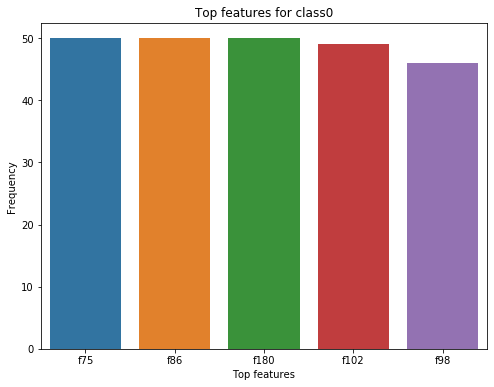

In [372]:
class0_topfreqs = []
for i in class0_topfeatures:
    class0_topfreqs.append(freqs0[i])
plt.figure(figsize = (8,6))
plt.xlabel('Top features')
plt.ylabel('Frequency')
plt.title('Top features for class0')    
sns.barplot(x = class0_topfeatures, y = class0_topfreqs )

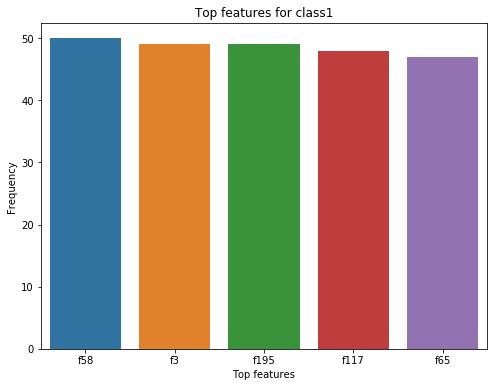

In [371]:
class1_topfreqs = []
for i in class1_topfeatures:
    class1_topfreqs.append(freqs1[i])
plt.figure(figsize = (8,6))
plt.xlabel('Top features')
plt.ylabel('Frequency')
plt.title('Top features for class1')
sns.barplot(x = class1_topfeatures, y = class1_topfreqs )

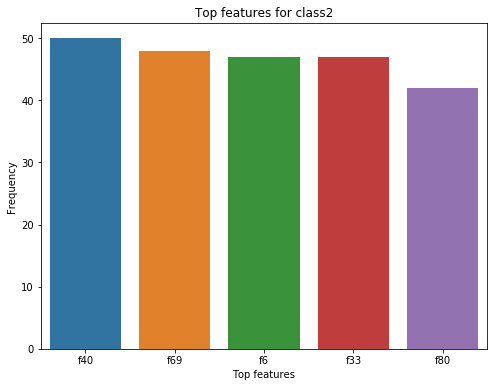

In [375]:
class2_topfreqs = []
for i in class2_topfeatures:
    class2_topfreqs.append(freqs2[i])
plt.figure(figsize = (8,6))
plt.xlabel('Top features')
plt.ylabel('Frequency')
plt.title('Top features for class2')    
sns.barplot(x = class2_topfeatures, y = class2_topfreqs )

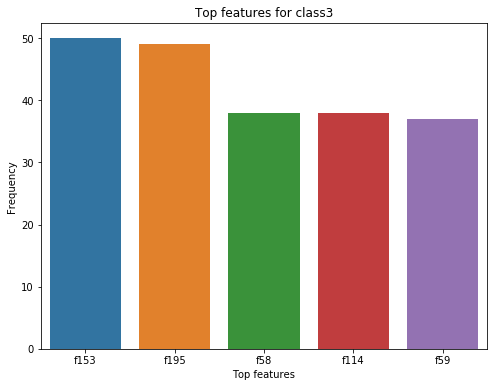

In [376]:
class3_topfreqs = []
for i in class3_topfeatures:
    class3_topfreqs.append(freqs3[i])
plt.figure(figsize = (8,6))
plt.xlabel('Top features')
plt.ylabel('Frequency')
plt.title('Top features for class3')    
sns.barplot(x = class3_topfeatures, y = class3_topfreqs )

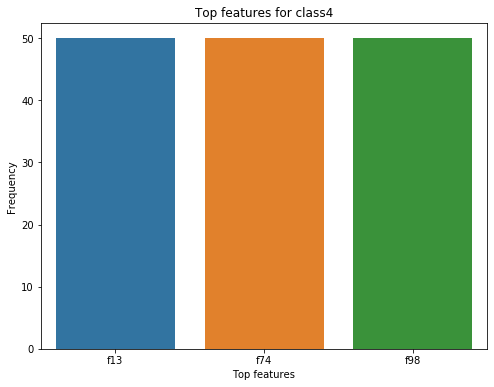

In [379]:
class4_topfreqs = []
for i in class4_topfeatures:
    class4_topfreqs.append(freqs4[i])
plt.figure(figsize = (8,6))
plt.xlabel('Top features')
plt.ylabel('Frequency')
plt.title('Top features for class4')      
sns.barplot(x = class4_topfeatures, y = class4_topfreqs )